# SI671 Project: Books Recommendation

## Load Data from Google Drive

In [55]:
# If run on colab
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#import os

#os.chdir('/content/drive/Shareddrives/SI671 project')

## Part0 Basic Data Exploration¶

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from wordcloud.wordcloud import WordCloud, STOPWORDS
!pip install surprise
from surprise import SVD, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNBaseline, SVDpp, NMF
from surprise import Dataset, Reader, accuracy
import os
from surprise.model_selection import GridSearchCV
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from skimage import io
import matplotlib.pyplot as plt
!pip install rank_bm25
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from rank_bm25 import BM25Plus
from sklearn.feature_extraction.text import CountVectorizer

You should consider upgrading via the '/Users/zhangyueyang/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/zhangyueyang/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangyueyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
rating = pd.read_csv( 'ratings.csv' )
to_read = pd.read_csv( 'to_read.csv' )
book = pd.read_csv( 'books.csv' )
tag = pd.read_csv( 'tags.csv' )
book_tag = pd.read_csv( 'book_tags.csv')

#### Dataset: rating

In [ ]:
print("shape", rating.shape, "\nunique users#", len(rating.user_id.unique()), "\nunique books#", len(rating.book_id.unique()))
rating.head(2)

shape (5976479, 3) 
unique users# 53424 
unique books# 10000


,user_id,book_id,rating
0,1,258,5
1,2,4081,4


###### There are 53424 users (1 to 53424) and 10000 books (1 to 10000) in the rating dataset.

In [ ]:
rating['rating'].describe()

count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

(array([ 124195.,  359257., 1370916., 2139018., 1983093.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

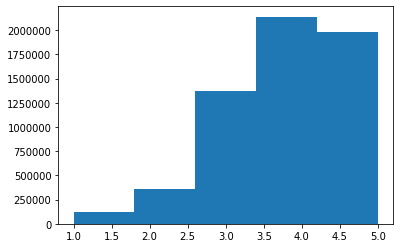

In [ ]:
plt.hist(rating['rating'], bins=5)

In [ ]:
rating_count = rating.groupby('rating').size()

In [ ]:
rating_count

rating
1     124195
2     359257
3    1370916
4    2139018
5    1983093
dtype: int64

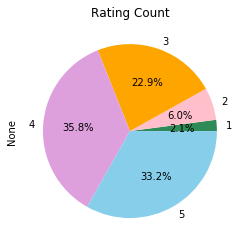

In [ ]:
import matplotlib.pyplot as plt
rating_count.plot(kind='pie',title='Rating Count',autopct='%1.1f%%',colors = ['seagreen','pink','orange','plum','skyblue'])

###### The user_id and book_id are contiguous.Most rating scores are 4 and 5.

#### Dataset: books

In [ ]:
print("unique books#", len(book.book_id.unique()), "\nunique authors#", len(book.authors.unique()))
book.head(2)

unique books# 10000 
unique authors# 4664


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [ ]:
book.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [ ]:
#book[['average_rating','ratings_count','ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].describe()

(array([  10.,  181., 2770., 6420.,  619.]),
 array([2.47, 2.94, 3.41, 3.88, 4.35, 4.82]),
 <a list of 5 Patch objects>)

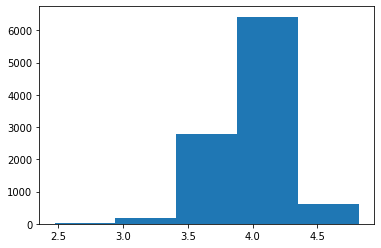

In [ ]:
plt.hist(book['average_rating'], bins=5)

In [ ]:
bins = [0,1,2,3,4,5]
dummies = pd.cut(book['average_rating'],bins,labels=[1,2,3,4,5]).reset_index()

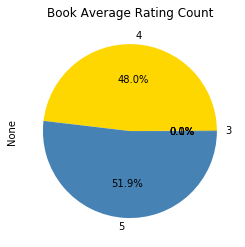

In [ ]:
book_rating_count = dummies.groupby('average_rating').size()
book_rating_count.plot(kind='pie',title='Book Average Rating Count',autopct='%1.1f%%', colors = ['pink','plum','olive','gold','steelblue'])

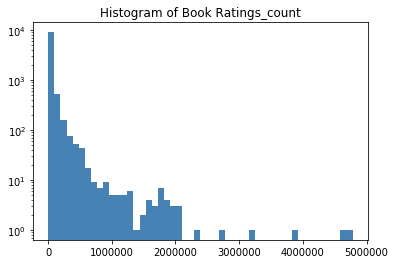

In [ ]:
plt.hist(book['ratings_count'], color = 'steelblue', bins=50)
plt.yscale('log')
plt.title("Histogram of Book Ratings_count")
plt.show()

###### There are 10000 books and 4664 authors in total, so averagely each author wrote about 2.14 books. 
###### Most of the average ratings are 4 and 5.

#### Dataset: To_read

In [ ]:
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [ ]:
len(to_read.user_id.unique())/53424

0.9147761305780173

In [ ]:
len(to_read.book_id.unique())/10000

0.9986

###### 91% of the users have some books marked to read and 99.9% books have been marked to read by somebody

#### tags and books

In [ ]:
tag.sample(5)

,tag_id,tag_name
7552,7552,clothbound-classics
8036,8036,consulting
21605,21605,nix
12999,12999,genre-cookbooks
12695,12695,funplunge


In [ ]:
book_tag.head(3)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


The most frequent tags

In [ ]:
tag_counts = book_tag[['tag_id','count']].groupby(['tag_id']).sum().reset_index().sort_values(by='count',ascending = False )
#tag_counts.head( 20 )
tag_counts = pd.merge(tag_counts, tag, left_on='tag_id', right_on='tag_id', how='inner')
tag_counts_new = tag_counts[['tag_name','count']]
tag_counts_new.head()

,tag_name,count
0,to-read,140718761
1,currently-reading,7507958
2,favorites,4503173
3,fiction,3688819
4,fantasy,3548157


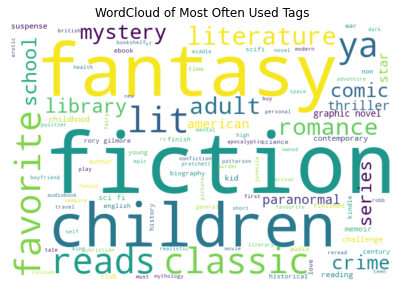

<Figure size 720x432 with 0 Axes>

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add('books')
stopwords.add('book')
stopwords.add('read')
freq_tag = ' '.join(tag_counts_new['tag_name'][0:500])
tagcloud = WordCloud(background_color="white", width = 300, height = 200, scale=2,stopwords=stopwords, max_words=500).generate(freq_tag)
plt.figure(figsize = (7,10))
plt.imshow(tagcloud, interpolation="bilinear", cmap = plt.cm.autumn)
plt.axis('off')
plt.title('WordCloud of Most Often Used Tags')
plt.figure(figsize = (10,6))
plt.show()


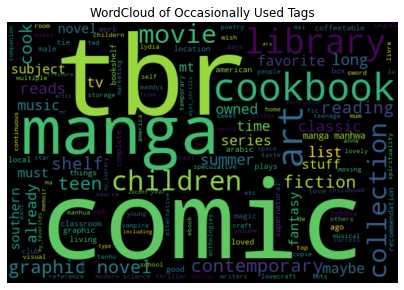

<Figure size 720x432 with 0 Axes>

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add('books')
stopwords.add('book')
stopwords.add('read')
freq_tag = ' '.join(tag_counts_new['tag_name'][-500:-1])
tagcloud = WordCloud(background_color="black", width = 300, height = 200, scale=2,stopwords=stopwords, max_words=500).generate(freq_tag)
plt.figure(figsize = (7,10))
plt.imshow(tagcloud, interpolation="bilinear", cmap = plt.cm.autumn)
plt.axis('off')
plt.title('WordCloud of Occasionally Used Tags')
plt.figure(figsize = (10,6))
plt.show()

###### The tags that were used the most often by users include the messages like "fantacy", "fiction","literature","romance",etc. The tags that were used occasionally by users include the messages like "comic', "manga", "cookbook","movie", etc.

## Part 1 Collaborative filtering based on surprise library¶

##### For the entire 'rating' dataframe, we randomly selected 25000 users and 5000 books, the train dataset is created from the 'rating' dataframe with these users and books, which takes 25% of the entire dataset. Increasing the size of the train set will not change the accuracy too much. Then the rest part of the 'rating' dataframe will be used as the test set. So, the train and test sets don't have any overlap.

In [5]:
random.seed(671)
user_sample = rating[["user_id"]].drop_duplicates().sample(n=25000).values.tolist()
book_sample = rating[["book_id"]].drop_duplicates().sample(n=5000).values.tolist()

sample_data = rating.loc[rating['user_id'].isin(user_sample)&rating['book_id'].isin(book_sample)]


In [ ]:
sample_data.shape

In [ ]:
test_data = pd.merge(rating, sample_data, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [ ]:
test_data.head(1)

In [ ]:
testset = list(test_data.to_records(index=False))

##### Do the train validation split on the train set

In [ ]:
train, val = train_test_split(sample_data, test_size=0.25) 

In [ ]:
reader = Reader(rating_scale=(0, 5), line_format='user item rating', sep=',', skip_lines=1)
data = Dataset.load_from_df(train[['user_id', 'book_id', 'rating']], reader=reader)

In [ ]:
valset = list(val.to_records(index=False))

#### Use the base line model to fit the train set 

In [ ]:
model = BaselineOnly()
cross_validate(model, data, cv=5, verbose=1)

In [ ]:
predict_base = model.test(valset)
print("The RMSE of Baseline model is", accuracy.rmse(predict_base))
print("The MAE of Baseline model is", accuracy.mae(predict_base))

#### First, we calculated the basic MAE values of different Collaborative filtering algorithm, and tried to filter the best algorithm. 

In [ ]:
# Comment because takes too long. Uncomment if want to run.
'''
models = [SVD(),
         NormalPredictor(),
         BaselineOnly(),
         KNNBasic(),
         KNNWithMeans(),
         KNNBaseline(),
         #KNNWithZScore(),
         SVDpp(),
         NMF()
         ]

mae_mean = []
for model in models:
    mae = cross_validate(model, data, measures=['MAE'], cv=3, verbose=0)
    mae_mean.append(mae['test_mae'].mean())
'''

In [ ]:
mae_mean # The result of multiple models

##### For model based approaches, SVDpp seems to be the best algorithm, for User-Based and Item-Based algorithm, KNNwithMeans seems to be the best model. 

### User-Based vs Item-Based Collaborative Filtering

#### Tune the KNNwithMeans model

In [ ]:
#use a relative small dataset to tune the model
random.seed(671)
user_sample_tune = rating[["user_id"]].drop_duplicates().sample(n=5000).values.tolist()
book_sample_tune = rating[["book_id"]].drop_duplicates().sample(n=1000).values.tolist()
sample_data_tune = rating.loc[rating['user_id'].isin(user_sample_tune)&rating['book_id'].isin(book_sample_tune)]
data_tune = Dataset.load_from_df(sample_data_tune[['user_id', 'book_id', 'rating']], reader=reader)

In [ ]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

knn_tune = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
knn_tune.fit(data_tune)

print(knn_tune.best_score["rmse"])
print(knn_tune.best_params["rmse"])

In [ ]:
from surprise import KNNWithMeans
sim_options = {
    "name": 'msd',
    "min_support":3,
    "user_based": False,
}
knn = KNNWithMeans(sim_options=sim_options)
cross_validate(knn, data, cv=5, verbose=True)

In [ ]:
#predict_knn = [i[3] for i in knn.test(testset)]
#mae_knn = mean_absolute_error(truth, predict_knn)
#rmse_knn = sqrt(mean_squared_error(truth, predict_knn))
#print("The MAE of KNNwithMeans model is",mae_knn)
#print("The RMSE of KNNwithMeans model is",rmse_knn)

In [ ]:
predict_knn_item = knn.test(valset)
print("The RMSE of item-based KNN is", accuracy.rmse(predict_knn_item))
print("The MAE of item-based KNN is", accuracy.mae(predict_knn_item))

In [ ]:
sim_options = {
    "name": 'msd',
    "min_support":3,
    "user_based": True, 
}
knn_user = KNNWithMeans(sim_options=sim_options)
cross_validate(knn_user, data, cv=5, verbose=True)

In [ ]:
predict_knn_user = knn_user.test(valset)
print("The RMSE of user-based KNN is", accuracy.rmse(predict_knn_user))
print("The MAE of user-based KNN is", accuracy.mae(predict_knn_user))

### Model-based Collaborative Filtering

In [ ]:
param_grid = {'n_factors': [20,30],
    "n_epochs": [20, 50],
    "lr_all": [0.002, 0.007],
    "reg_all": [0.02, 0.1]
}
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3, n_jobs=-1)

gs.fit(data_tune)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

In [ ]:
svdpp = SVDpp(reg_all=0.1)
cross_validate(svdpp, data, cv=5, verbose=True)

In [ ]:
predict_svdpp = svdpp.test(valset)
print("The RMSE of SVDpp is", accuracy.rmse(predict_svdpp))
print("The MAE of SVDpp is", accuracy.mae(predict_svdpp))

##### Based on the evaluation results of both train and validation set,the SVDpp algorithm gives the highest accuracy. Thus we plan to use this model to do the recommendation.

### Recommendation by predicted rating

In [ ]:
prediction = svdpp.test(testset)
prediction[0]

In [ ]:
rating_list = []
for i in prediction:
    rating_list.append(i[3])

test_data_new = test_data
test_data_new['Predict_rating']=rating_list
test_data_new.sample(5)

In [ ]:
predict_list = [i[3] for i in prediction]
truth = test_data['rating'].tolist()
mae_svdpp = mean_absolute_error(truth, predict_list)
rmse_svdpp = sqrt(mean_squared_error(truth, predict_list))
print("The MAE of KNNwithMeans model is",mae_svdpp)
print("The RMSE of KNNwithMeans model is",rmse_svdpp)

In [ ]:
test_data_new.Predict_rating.describe()

In [ ]:
recommendation = test_data_new[test_data_new.Predict_rating >= 4.0]
recommendation.head(1)

In [ ]:
recommendation = recommendation.drop(columns=['rating','Predict_rating'])
recommendation.set_index(['user_id']).stack()

##### We used the test set to do the prediction and used SVDpp model to predict the rating. The books with the predict rating >= 4.0 will be recommended to the users. So, the final result is shown above (with a list of book_id for each user).

## Part 3 Content-Based Filtering

In [6]:
stop = stopwords.words('english')
tags_join_DF = pd.merge(book_tag, tag, left_on='tag_id', right_on='tag_id', how='inner')
books_with_tags = pd.merge(book, tags_join_DF, left_on='goodreads_book_id', right_on='goodreads_book_id', how='inner')
temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
books = pd.merge(book, temp_df, left_on='book_id', right_on='book_id', how='inner')
books['authors'] = books['authors'].apply(lambda x: str.lower(x.replace(" ", "")))
books['corpus'] = (pd.Series(books[['authors', 'tag_name']].fillna('').values.tolist()).str.join(' '))
books['clean_title'] = books['title'].apply(lambda x: ' '.join([word for word in str(x).lower().split() if word not in (stop)]))

In [7]:
def tfidf_countVectorizer(method = 0):
    if method == 0:
        corpus = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stop)
    else:
        corpus = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stop)

    matrix_corpus = corpus.fit_transform(books['corpus'])
    cosine_sim_corpus = linear_kernel(matrix_corpus, matrix_corpus)
    cosine_sim_corpus = cosine_sim_corpus
    titles = books['title']
    indices1 = pd.Series(books.index, index=books['title'])

    return cosine_sim_corpus,indices1


In [8]:
def calculate_bm25():
   
    corpus = books['clean_title']

    bm25 = BM25Plus(corpus)#k1=1.5, b=0.75, delta=1
    
    return bm25, corpus

bm25, corpus = calculate_bm25()

def get_title(query):
    tokenized_query = ' '.join([word for word in query.lower().split() if word not in (stop)])
    doc_scores = bm25.get_scores(tokenized_query)
    title_index = (-doc_scores).argsort()[:1][0]
    return books.iloc[title_index]['title']

In [9]:
# Used Bayes average estimation as baseline rating.
def weighted_rating(x,C,m):
    v = x['ratings_count']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

def show_image(x, num=5):
    title = x.head(num)['title'].tolist()
    image = [io.imread(i) for i in x.head(num)['image_url'].tolist()]
    plt.figure(figsize=(35,25))
    for i in range(num):
        plt.subplot(2,5,i+1)
        plt.title(title[i])
        plt.imshow(image[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    

# Function that get book recommendations based on the cosine similarity score of books tags
def content_recommendations(query, combined_rates = False, books_num = 5):
    title = get_title(query)
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores[1:3*books_num]]
    book_temp = books.iloc[book_indices][['title', 'ratings_count', 'average_rating', 'original_publication_year','image_url','small_image_url']]
    book_temp = book_temp.sort_values(by=['average_rating'],ascending=False)
    #return book_temp

    if not combined_rates:
        show_image(book_temp)
        return book_temp.head(books_num)
    else:
        C = book_temp['average_rating'].mean()
        m = book_temp['ratings_count'].astype('int').quantile(0.025)
        high_rate = book_temp[(book_temp['ratings_count'] >= m)]
        high_rate['weighted_rate'] = high_rate.apply(weighted_rating, C=C, m=m, axis=1)
        high_rate = high_rate.sort_values('weighted_rate', ascending=False)
        show_image(high_rate,books_num)
        return high_rate.head(books_num)
    
    

In [10]:
books.head(1)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_name,corpus,clean_title
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,suzannecollins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,to-read fantasy favorites currently-reading yo...,suzannecollins to-read fantasy favorites curre...,"hunger games (the hunger games, #1)"


If set combined_rates as False, the model will return the most similar books compared to the input one. If set as True, the model will take into account the adjusted baseline average rating and return the highly rated similar books.

In [11]:
cosine_sim_corpus,indices1 = tfidf_countVectorizer()

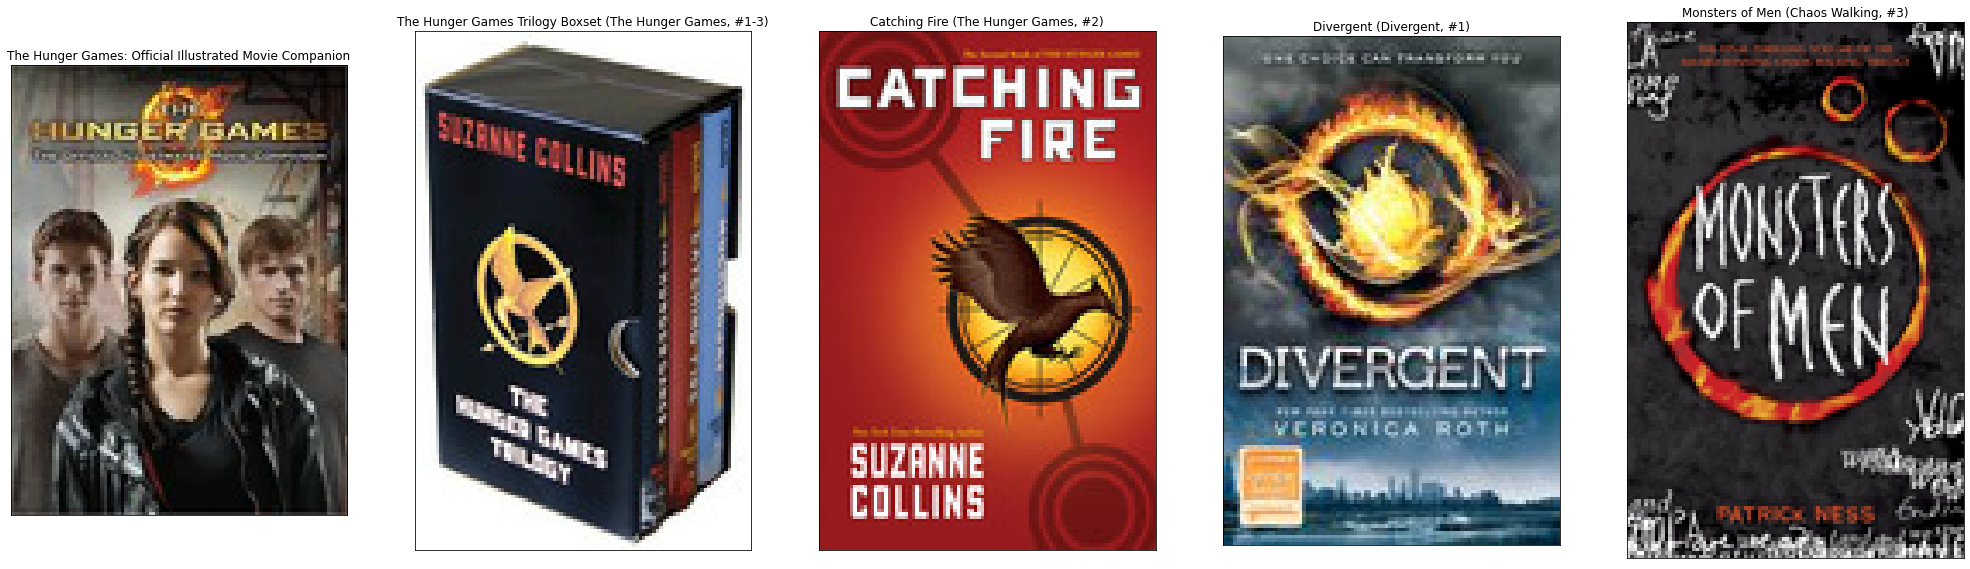

['The Hunger Games: Official Illustrated Movie Companion',
 'The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)',
 'Catching Fire (The Hunger Games, #2)',
 'Divergent (Divergent, #1)',
 'Monsters of Men (Chaos Walking, #3)']

In [12]:
r1 = content_recommendations("The Hunger Games",True)
r1_list = r1['title'].tolist()
r1_list

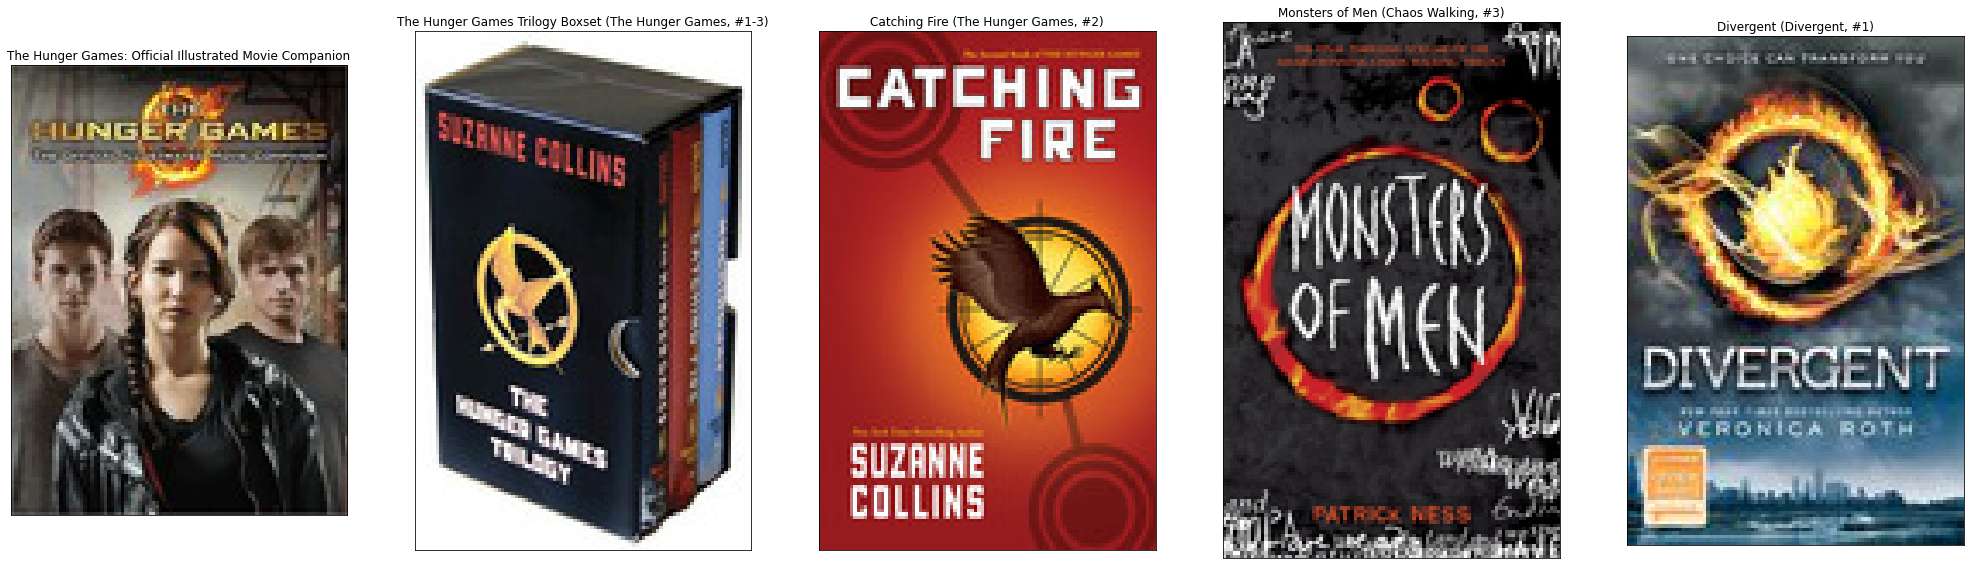

['The Hunger Games: Official Illustrated Movie Companion',
 'The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)',
 'Catching Fire (The Hunger Games, #2)',
 'Monsters of Men (Chaos Walking, #3)',
 'Divergent (Divergent, #1)']

In [13]:
r2 = content_recommendations("The Hunger Games",False)
r2_list = r2['title'].tolist()
r2_list

In [14]:
cosine_sim_corpus,indices1 = tfidf_countVectorizer(method=1)

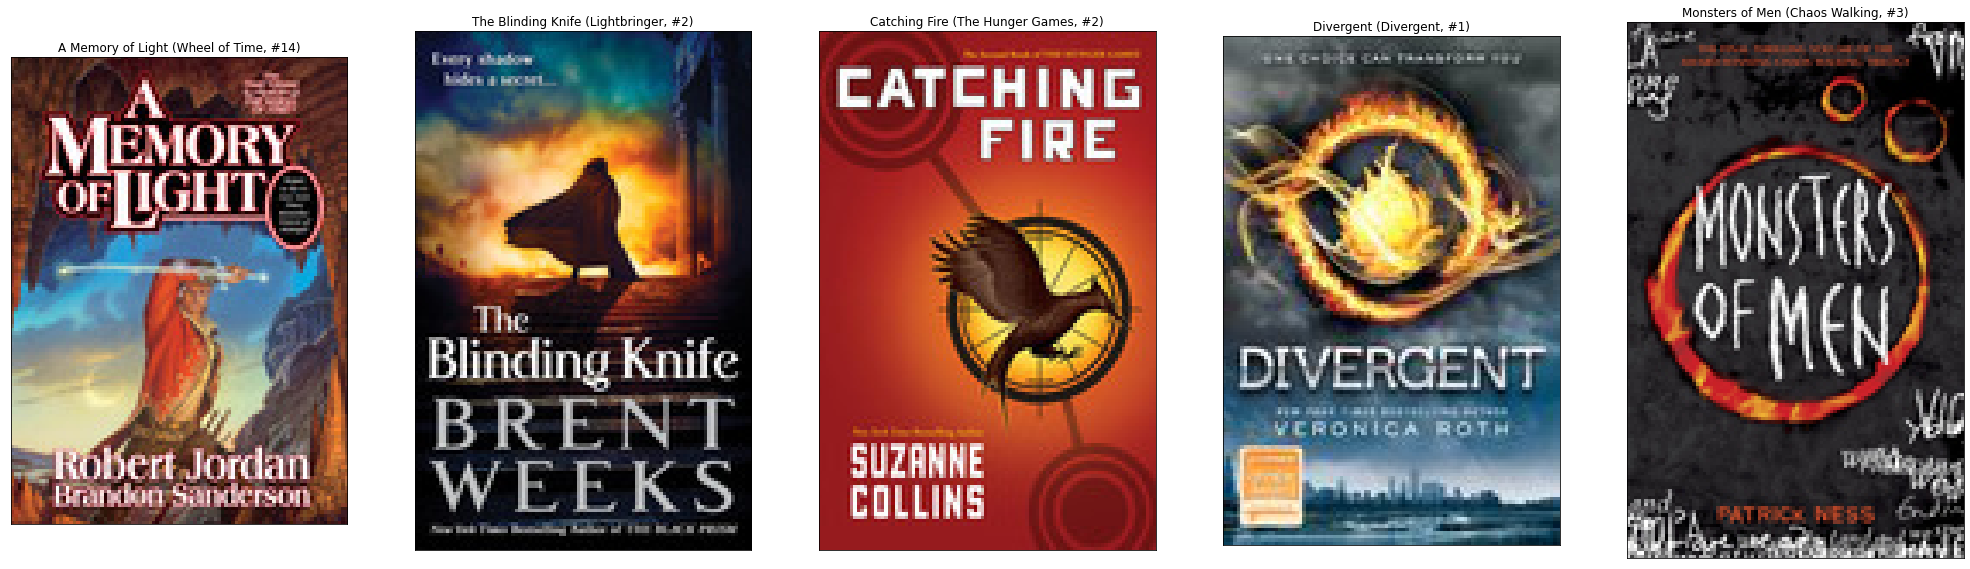

['A Memory of Light (Wheel of Time, #14)',
 'The Blinding Knife (Lightbringer, #2)',
 'Catching Fire (The Hunger Games, #2)',
 'Divergent (Divergent, #1)',
 'Monsters of Men (Chaos Walking, #3)']

In [15]:
r3 = content_recommendations("The Hunger Games",True)
r3_list = r3['title'].tolist()
r3_list

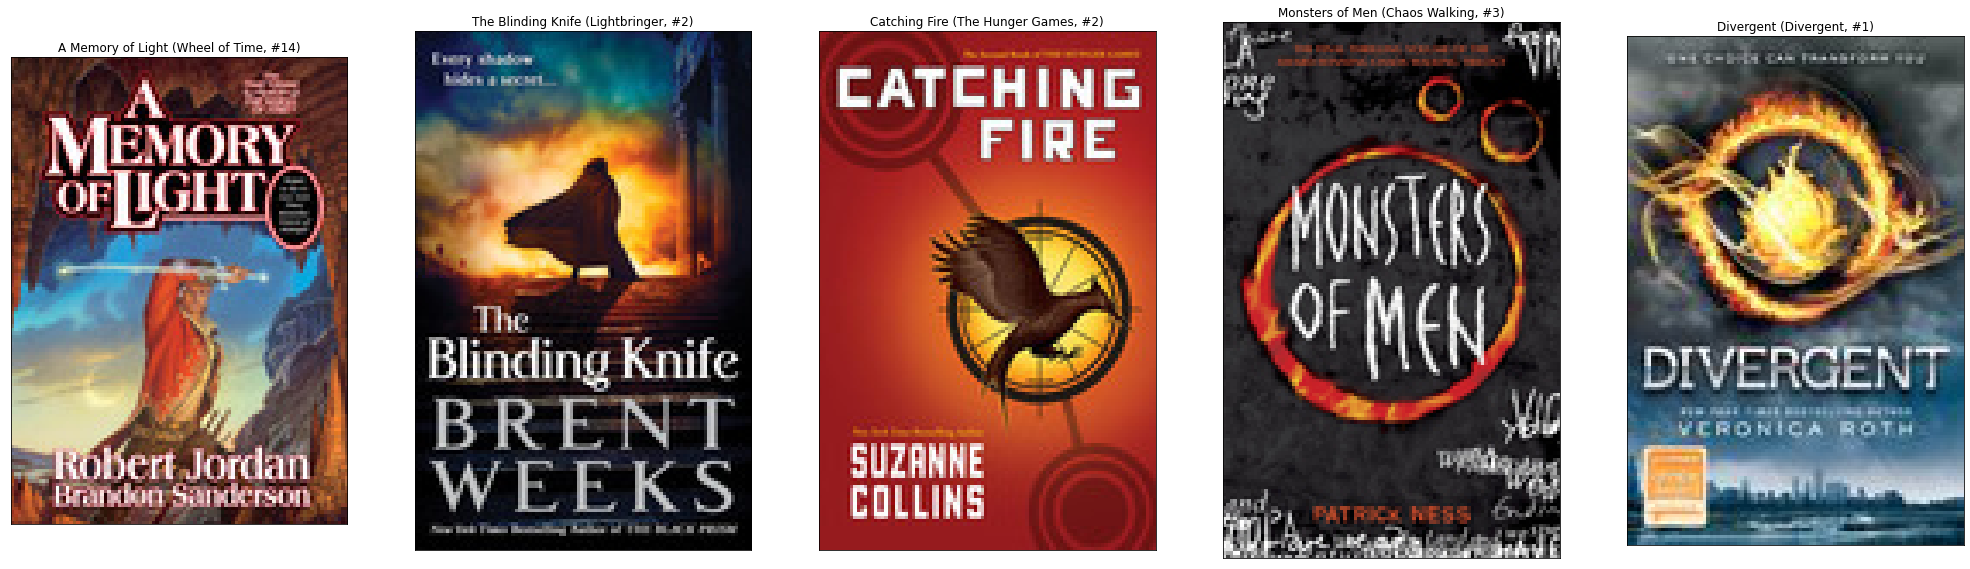

['A Memory of Light (Wheel of Time, #14)',
 'The Blinding Knife (Lightbringer, #2)',
 'Catching Fire (The Hunger Games, #2)',
 'Monsters of Men (Chaos Walking, #3)',
 'Divergent (Divergent, #1)']

In [16]:
r4 = content_recommendations("The Hunger Games",False)
r4_list = r4['title'].tolist()
r4_list